<a href="https://colab.research.google.com/github/Arindam75/Audio-Resnet/blob/main/Deep_256_Skip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import datetime
import pandas as pd

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add,Dense,Flatten,Dropout,Input,Activation,MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
import pandas as pd
from tensorflow.keras.regularizers import l2

In [ ]:
path='/content/drive/My Drive/Environmental'
path

'/content/drive/My Drive/Environmental'

In [ ]:
data = np.load(path+'/Training Data1.npz')
X_train=data['name1']
y_train=data['name2']

data = np.load(path+'/Validation Data1.npz')
X_val=data['name1']
y_val=data['name2']

In [ ]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_val=X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(24212, 13, 9, 1)
(24212, 10)
(71, 13, 9, 1)
(71, 10)


In [ ]:
def generator(X,y,batch_size):
  while True:
    samples=X.shape[0]
    batches=samples//batch_size
    
    for batch in range(0,batches):
        start=batch*batch_size
        stop=batch*batch_size+batch_size
        yield X[start:stop],y[start:stop]
    yield X[stop:],y[stop:]

In [ ]:
train_batch_size=32
val_batch_size=32
num_epochs=150

num_train_sequences=X_train.shape[0]
num_val_sequences=X_val.shape[0]

train_generator = generator(X_train, y_train,train_batch_size)
val_generator = generator(X_val, y_val, val_batch_size)

if (num_train_sequences%train_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/train_batch_size)
else:
    steps_per_epoch = (num_train_sequences//train_batch_size) + 1

if (num_val_sequences%val_batch_size) == 0:
    validation_steps = int(num_val_sequences/val_batch_size)
else:
    validation_steps = (num_val_sequences//val_batch_size) + 1

In [ ]:
my_input=X_train.shape[1:]
X_input = Input(my_input)

# 1st Stage
X = Conv2D(16, (3, 3), strides=(1, 1), name='Conv1', padding='same',kernel_initializer='glorot_normal',activation='relu')(X_input)
X = BatchNormalization(axis=3, name='BN_Conv1')(X)


# 2nd Stage
X = Conv2D(32, (3, 3), strides=(1, 1), name='Conv2', padding='same',kernel_initializer='glorot_normal',activation='relu')(X)
X = BatchNormalization(axis=3, name='BN_Conv2')(X)
X_skip=X
X_skip = Conv2D(256,(1, 1), strides = (1,1), name='Identity',padding = 'same',kernel_initializer = 'glorot_normal')(X_skip)

# 3rd Stage
X = Conv2D(64, (3,3), strides=(1, 1), name='Conv3', padding='same',kernel_initializer='glorot_normal',activation='relu')(X)
X = BatchNormalization(axis=3, name='BN_Conv3')(X)

# 4th Stage
X = Conv2D(128, (3,3), strides=(1, 1), name='Conv4', padding='same',kernel_initializer='glorot_normal',activation='relu')(X)
X = BatchNormalization(axis=3, name='BN_Conv4')(X)

#X_skip = BatchNormalization(axis=3, name='BN_Skip')(X_skip)


# 5th Stage
X = Conv2D(256, (3,3), strides=(1, 1), name='Conv5', padding='same',kernel_initializer='glorot_normal')(X)
X = Add(name='Addition')([X, X_skip])
X = BatchNormalization(axis=3, name='BN_Conv5')(X)
X = Activation('relu',name='Relu')(X)
X = MaxPooling2D()(X)

X=Dropout(0.5)(X)
X=Flatten()(X)

X=Dense(128,activation='relu',kernel_initializer='glorot_normal')(X)
X=Dense(64,activation='relu',kernel_initializer='glorot_normal')(X)
X=Dense(10,activation='relu',kernel_initializer='glorot_normal')(X)

model = Model(inputs = X_input, outputs = X, name='ResNet50')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

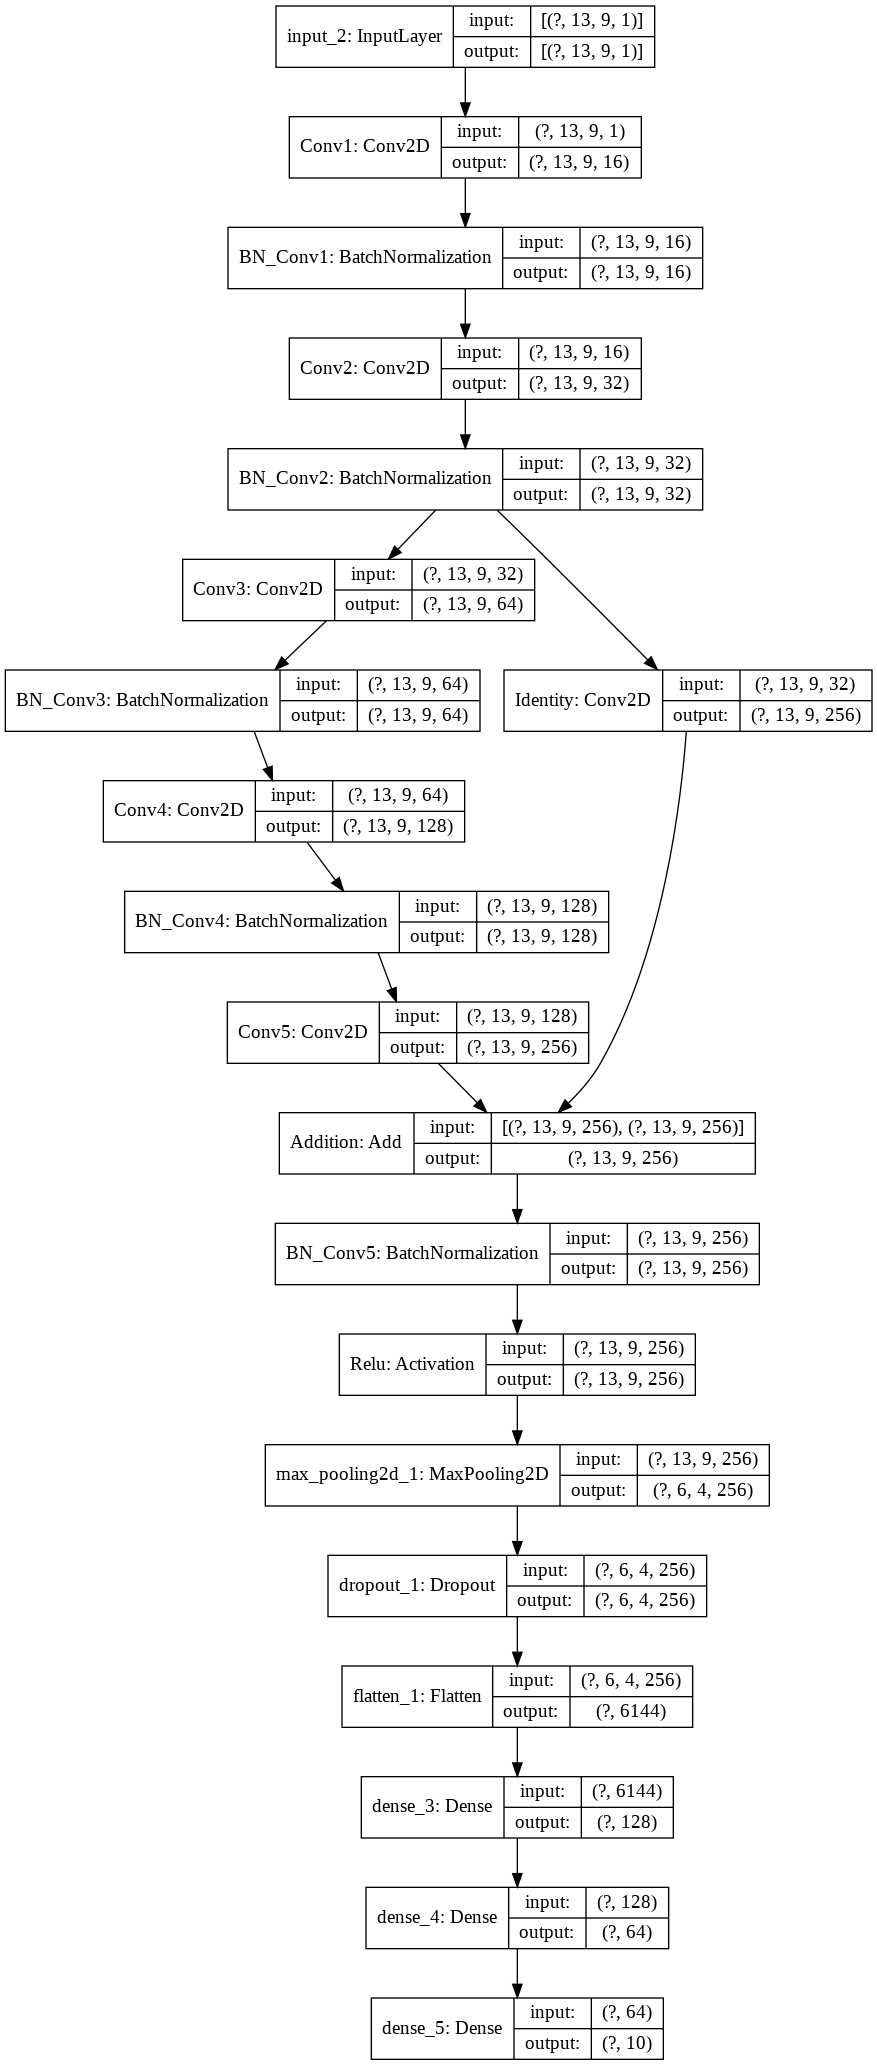

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 13, 9, 1)]   0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 13, 9, 16)    160         input_2[0][0]                    
__________________________________________________________________________________________________
BN_Conv1 (BatchNormalization)   (None, 13, 9, 16)    64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 13, 9, 32)    4640        BN_Conv1[0][0]                   
___________________________________________________________________________________________

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name =path+'/skip_256_init_config2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-{acc:.5f}-{val_acc:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint]

In [ ]:
filepath

'/content/drive/My Drive/Environmental/skip_256_init_config2_2020-11-0608_10_39.584473/model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-{acc:.5f}-{val_acc:.5f}.h5'

In [ ]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
757/757 [==============================] - ETA: 0s - loss: 4.4064 - acc: 0.3378
Epoch 00001: val_acc improved from -inf to 0.49296, saving model to /content/drive/My Drive/Environmental/skip_256_init_config2_2020-11-0608_10_39.584473/model-00001-4.40637-3.18513-0.33777-0.49296.h5
757/757 [==============================] - 4s 6ms/step - loss: 4.4064 - acc: 0.3378 - val_loss: 3.1851 - val_acc: 0.4930
Epoch 2/150
755/757 [============================>.] - ETA: 0s - loss: 2.9458 - acc: 0.4972
Epoch 00002: val_acc did not improve from 0.49296
757/757 [==============================] - 4s 5ms/step - loss: 2.9457 - acc: 0.4973 - val_loss: 3.6464 - val_acc: 0.4507
Epoch 3/150
750/757 [============================>.] - ETA: 0s - loss: 3.1484 - acc: 0.4043
Epoch 00003: val_acc improved from 0.49296 to 0.56338, saving model to /content/drive/My Drive/Environmental/skip_256_init_config2_2020-11-0608_10_39.58447

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


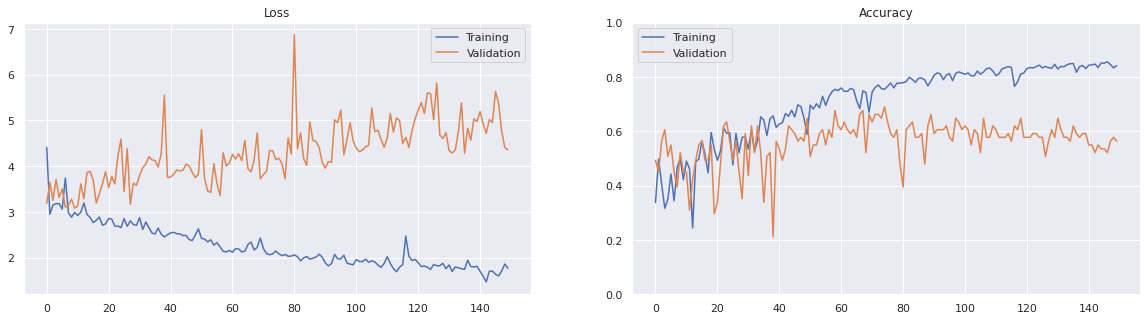

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

fig1, (ax1, ax2) = plt.subplots(1, 2)
fig1.set_figwidth(20)
fig1.set_figheight(5)

#fig1.suptitle('Model 3 Conv 3D Performance No Pre Processing')
ax1.plot(history.history['loss'],label='Training')
ax1.plot(history.history['val_loss'],label='Validation')
ax1.set_title('Loss')
#ax1.set_ylim(0, 3)
ax1.legend(loc="upper right")

ax2.plot(history.history['acc'],label='Training')
ax2.plot(history.history['val_acc'],label='Validation')
ax2.set_title('Accuracy')
ax2.set_ylim(0.0, 1)
ax2.legend(loc="bottom right")

In [ ]:
result_df_deep=pd.DataFrame(list(zip(history.history['acc'],history.history['val_acc'],
history.history['loss'],history.history['val_loss'])),columns =['Acc1', 'Val_Acc1','Loss1','Val_loss1'])

In [ ]:
result_df_deep.to_csv(path+'/skip_256_init_config2_2020-11-0608_10_39.584473/result_skip_df.csv')